# 6.6 Sourcing & Analyzing Time-Series Data

### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Federal Reserve Economic Data

### 1. Importing your libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings


warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [15]:
# Configuring API key 

quandl.ApiConfig.api_key = 'nD4UsJHDJJPnpxj5xjf1 '

In [16]:
# Importing Federal Reserve Economic Data for 'Natural Rate of Unemployment (Short-Term)
data = quandl.get('FRED/NROUST')

In [17]:
data.head(5)

,Value
Date,
1949-01-01,5.255053
1949-04-01,5.261516
1949-07-01,5.268013
1949-10-01,5.274564
1950-01-01,5.281182


In [18]:
data.shape

(332, 1)

In [19]:
data.columns

Index(['Value'], dtype='object')

In [20]:
type(data)

pandas.core.frame.DataFrame

### 2. Subsetting, wrangling, and cleaning time-series data

In [23]:
# Resetting index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [24]:
data_2.head()

,Date,Value
0,1949-01-01,5.255053
1,1949-04-01,5.261516
2,1949-07-01,5.268013
3,1949-10-01,5.274564
4,1950-01-01,5.281182


In [25]:
data.tail(5)

,Value
Date,
2030-10-01,4.294982
2031-01-01,4.289282
2031-04-01,4.283630
2031-07-01,4.278029
2031-10-01,4.272470


In [26]:
# Checking # of rows and columns
data.shape

(332, 1)

In [27]:
# Checking column info
data.columns

Index(['Value'], dtype='object')

In [28]:
# Checking data type
type(data)

pandas.core.frame.DataFrame

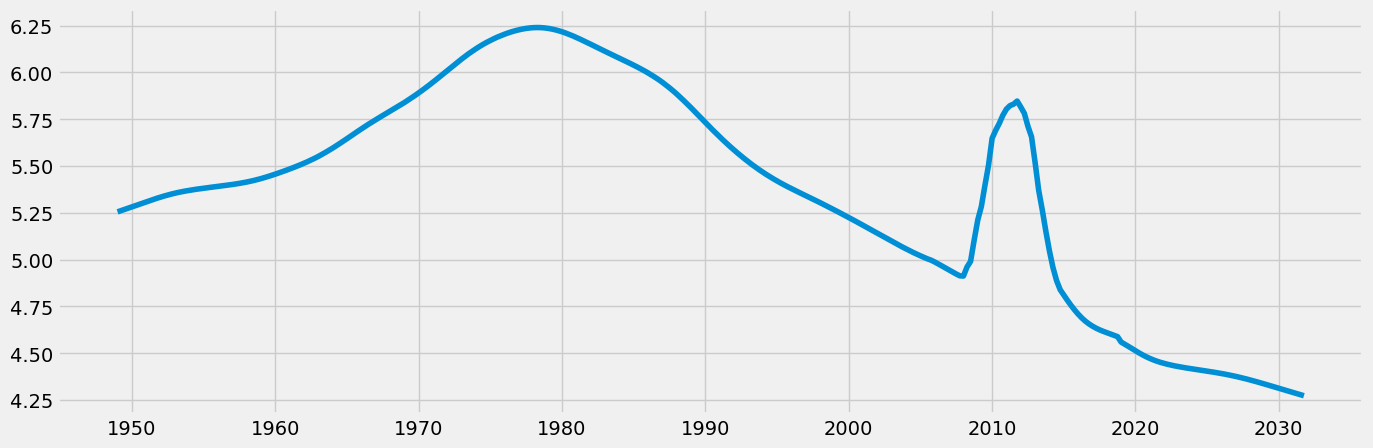

In [29]:
# Plotting the data using matplotlib
plt.figure(figsize=(15,5), dpi=100) 

plt.plot(data)

In [31]:
#Creating Subset
data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01') & (data_2['Date'] < '2021-06-01')]

Exluding the years before 1980 since the economic condition was different from nowadays. This was there would be less risk of bias. I´m also excluding data after 2021 since I´m not looking for predicting the future yet but the goal is to understand the data

In [32]:
data_sub.shape

(166, 2)

In [33]:
data_sub.head()

,Date,Value
124,1980-01-01,6.217371
125,1980-04-01,6.210709
126,1980-07-01,6.203388
127,1980-10-01,6.195496
128,1981-01-01,6.187123


In [34]:
# Setting the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) 
data_sub = data_sub.set_index('datetime') 
data_sub.drop(['Date'], axis=1, inplace=True)
data_sub.head()

,Value
datetime,
1980-01-01,6.217371
1980-04-01,6.210709
1980-07-01,6.203388
1980-10-01,6.195496
1981-01-01,6.187123


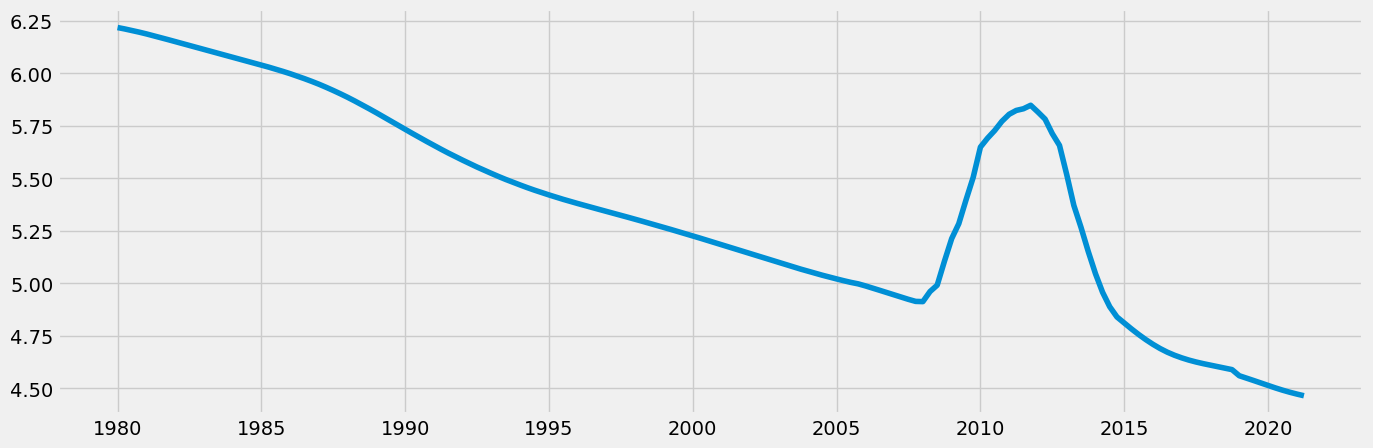

In [35]:
# Plotting the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [36]:
# Checking for missing values

data_sub.isnull().sum()

Value    0
dtype: int64

In [37]:
# Checking for duplicates

dups = data_sub.duplicated()
dups.sum()

0

There are no missing values and no duplicates

### 3. Time-series analysis: decomposition

In [39]:
# Decomposing the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [40]:
from pylab import rcParams

rcParams['figure.figsize'] = 18, 7

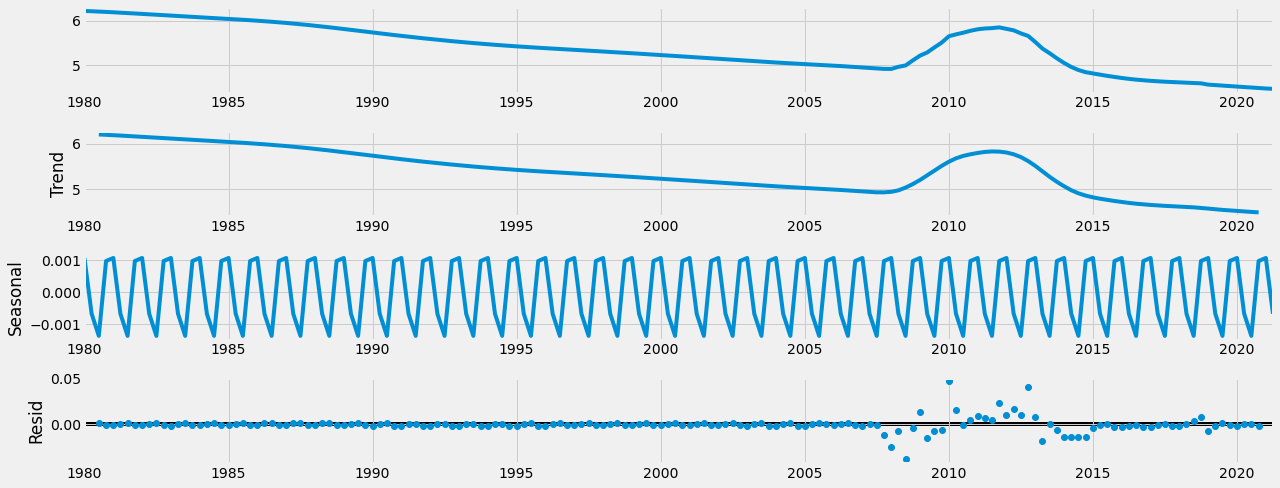

In [41]:
# Plotting the separate components

decomposition.plot()
plt.show()

The level and trend are the same. The trend decreases after 1980 and has a preak around 2010, but then it decreases once again. The seasonality shows season fluctuations at a regular interval. The noise represents the residual data which in this case, is not a lot. The only difference happens aroung 2010 which can be explained by the financial crisis in 2008. This would also explain the peak in the trend.

### 4. Testing for stationarity

In [44]:
# Importing adfuller() function, perform Dickey-Fuller Test, and apply test using function on time series

from statsmodels.tsa.stattools import adfuller 

def dickey_fuller(timeseries): 
    
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

dickey_fuller(data['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -0.686934
p-value                          0.850105
Number of Lags Used             17.000000
Number of Observations Used    314.000000
Critical Value (1%)             -3.451349
Critical Value (5%)             -2.870789
Critical Value (10%)            -2.571698
dtype: float64


The Test Statistic indicated the test results and it equals -0,69 while the p-value is larger than 0.05 indicating that the test is not "significant". The Test statistic is larger than the critical values, meaning that I can´t reject the null hypothesis. 

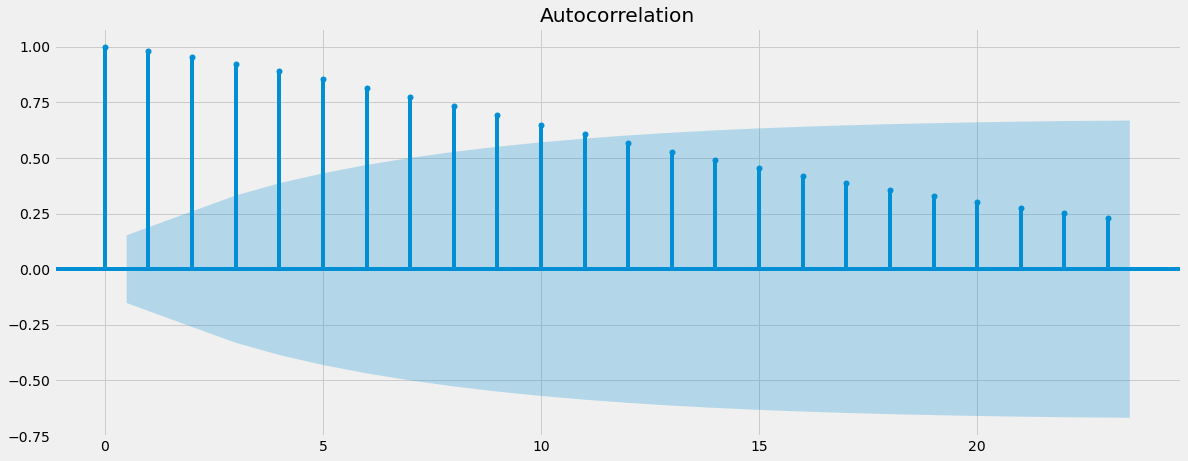

In [45]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
plot_acf(data_sub)
plt.show()

The lines go above the blue edge of the confidence interval, this means that the time series has quite a few lags correlated with each other. This also means that the data set is likely non-stationary. For the purpose of the analysis, the data needs to be stationary in order to be able to perfom predictive analysis

### 5. Stationarizing the Federal Reserve Economic Data


In [46]:
# Calculating difference between every values and its lag, then store results in new dataframe
data_diff = data - data.shift(1) 

In [47]:
# Removing any missing values
data_diff.dropna(inplace = True)

In [48]:
# Displaying dataframe
data_diff.head()

,Value
Date,
1949-04-01,0.006463
1949-07-01,0.006497
1949-10-01,0.006551
1950-01-01,0.006618
1950-04-01,0.006684


In [49]:
# Displaying column information
data_diff.columns

Index(['Value'], dtype='object')

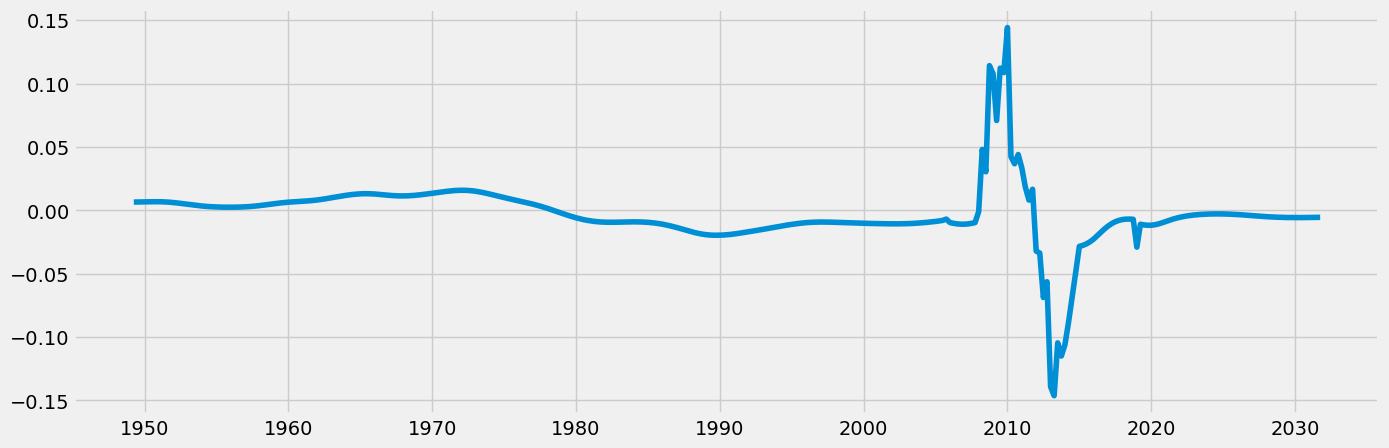

In [50]:
# Displaying time series with differencing
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [51]:
# Performing Dickey-Fuller test
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -2.959412
p-value                          0.038863
Number of Lags Used             16.000000
Number of Observations Used    314.000000
Critical Value (1%)             -3.451349
Critical Value (5%)             -2.870789
Critical Value (10%)            -2.571698
dtype: float64


The test-statistic is now -2.96 and it´s smaller than the critical values at 5% (-2.87) and at 10% (-2.57). As a result, the null hypothesis can be rejected and the time series is now stationary. The test result is also 'significant' as the p-value is less than 0.05.

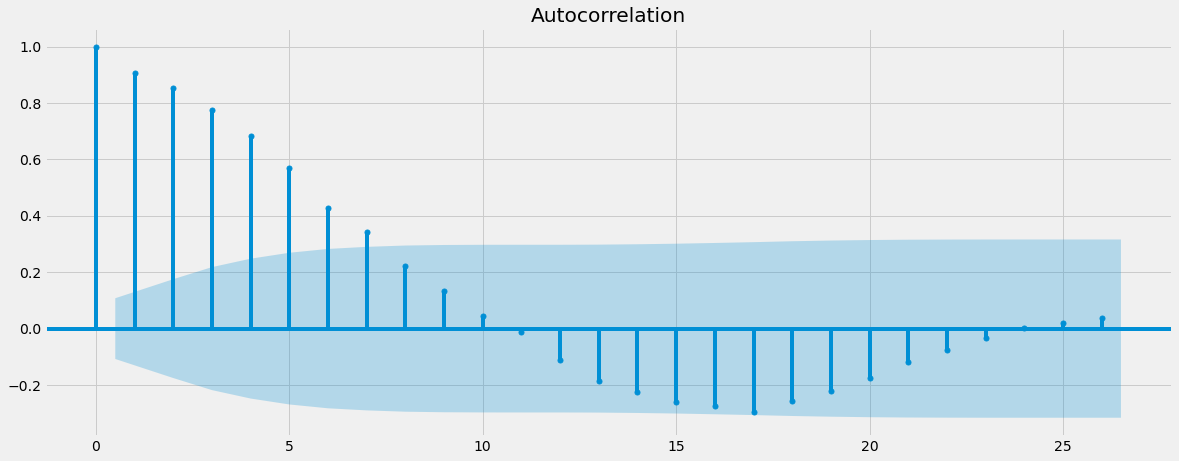

In [52]:
# Displaying autocorrelation
plot_acf(data_diff)
plt.show()

The data is more stationary than before even if there are still a few lines above the blue confidence interval. This indicates that despite the Dickey-Fuller test saying that the data is stationary, the stationarity is weak